In [2]:
import numpy as np
import random
import torch
import torch.nn as nn
import gymnasium as gym
import time
from tqdm import tqdm
import winsound
from torch.distributions import Normal, Categorical
from copy import deepcopy

from FlatOrientation import *
from PPO import *

import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns

from IPython.display import display, clear_output

sns.set_theme()

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 6.0)

%load_ext autoreload
%autoreload 2

## Ориентация КА, PPO

## I. Привидение в точку за 1 секунду

### Обучение

In [138]:
env = FlatOrientation(dt=1e-2, integration='Euler')

In [139]:
agent = PPO(
    state_dim=3,
    action_dim=1, 
    max_action=25, 
    observable_states=[0, 1, 2],
    gamma=1
)

# agent.pi_model = torch.load('models/flat_orientation_pi_140.pth')
# agent.v_model = torch.load('models/flat_orientation_v_140.pth')

In [140]:
train_ppo(
    env, 
    agent, 
    episode_n=10, 
    trajectory_n=500, 
    advantage='default',
)

0: mean reward = -165109.95682221948
1: mean reward = -26845.440479642315
2: mean reward = -6912.237012335189
3: mean reward = -2788.78076841979
4: mean reward = -1980.1859950627875
5: mean reward = -1639.2978826692042
6: mean reward = -1354.1063709817631
7: mean reward = -1180.8787362756566
8: mean reward = -991.3193357002493
9: mean reward = -863.2025646191071


In [141]:
history = []
history.extend(agent.history)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


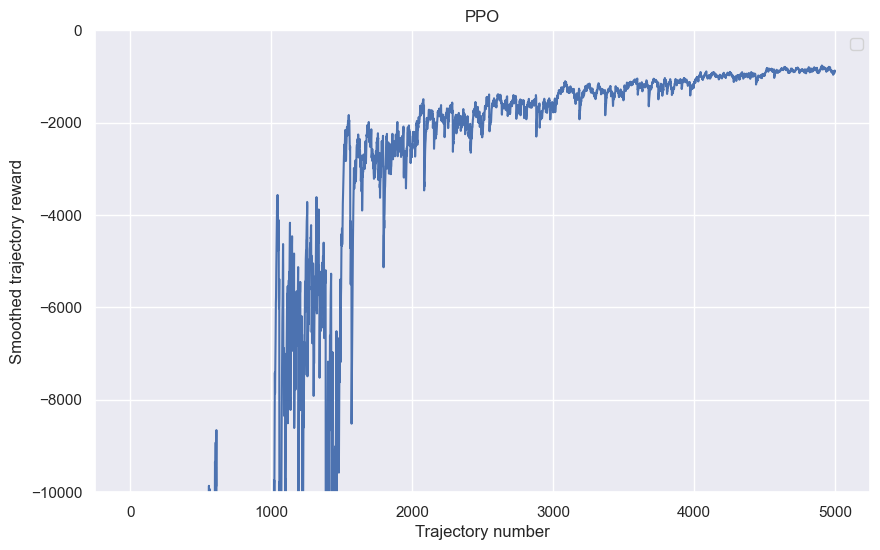

In [143]:
plot_history(history, ylim=[-10**4, 0])

### Валидация

In [144]:
validation_env = FlatOrientation(dt=1e-3)

In [145]:
class AnaliticalAgent(PPO):
    def __init__(self):
        self.discrete_action_space = False
        self.max_action = 1
        self.observable_states = [0, 1, 2]

    def get_action(self, state, prediction=False):
        return [6 * np.pi - 12 * np.pi * state[0]]

In [146]:
validation(validation_env, agent, validation_n=10, prediction=True)

-217.44377485816335

### Управление:

In [147]:
def get_reward(env, agent):
    traj = agent.get_trajectory(env, prediction=True, initial_state=np.array([0, 0, 0]))
    return sum(traj['rewards'])

In [148]:
get_reward(validation_env, agent)

-212.59558138157018

In [149]:
get_reward(validation_env, AnaliticalAgent())

-119.94210729691727

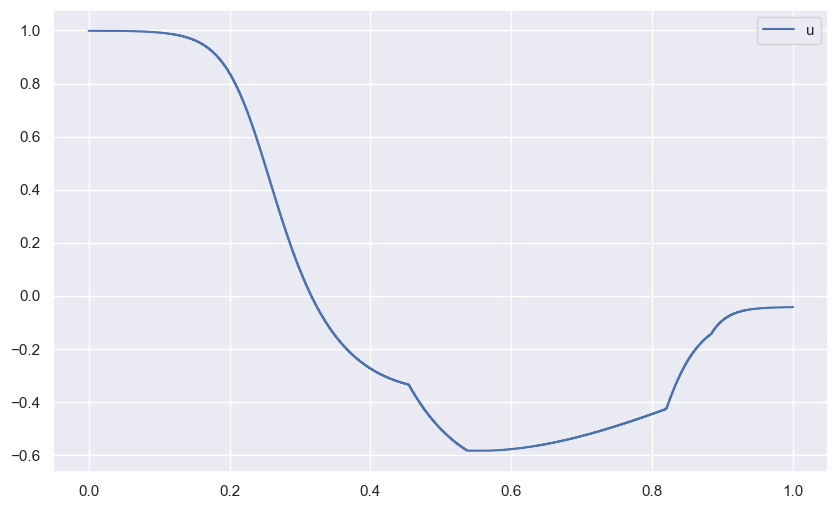

In [153]:
plot_u(validation_env, agent)

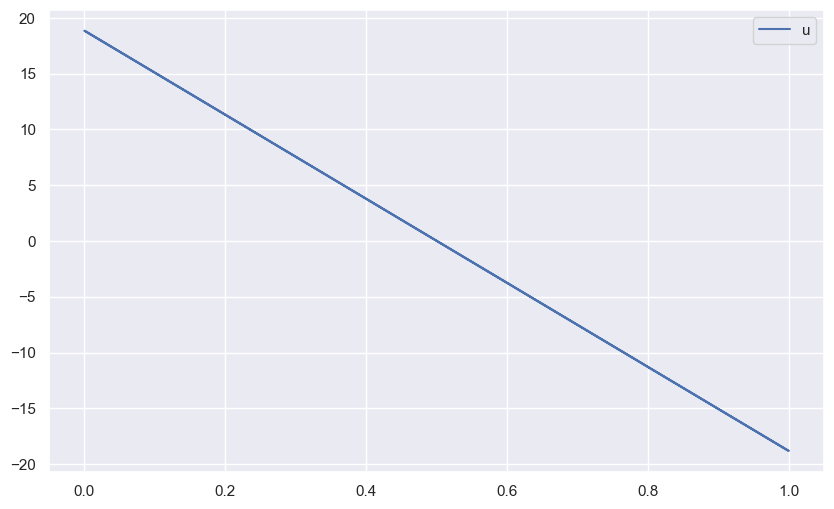

In [154]:
plot_u(validation_env, AnaliticalAgent())

0.009421636368116992 0.01884955592152448


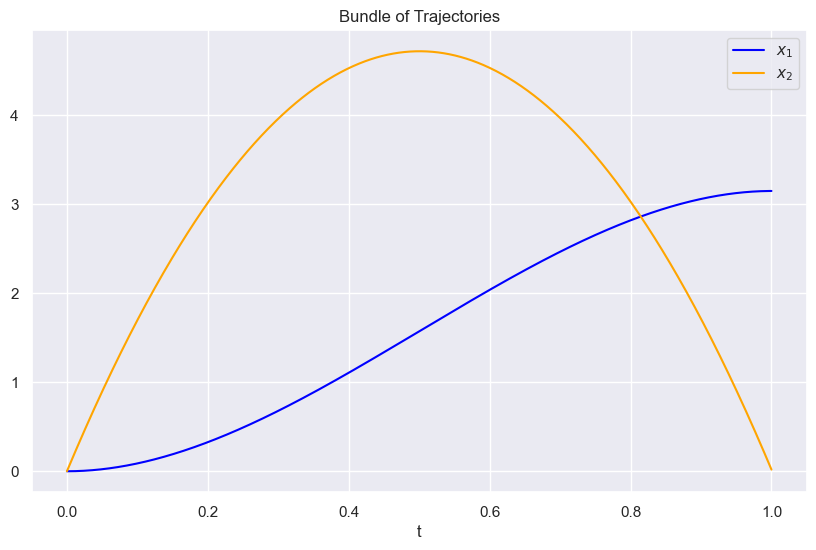

In [155]:
plot_sheaf(validation_env, AnaliticalAgent(), initial_state=[0, 0, 0])

-0.07461721200997751 0.009728449828926143


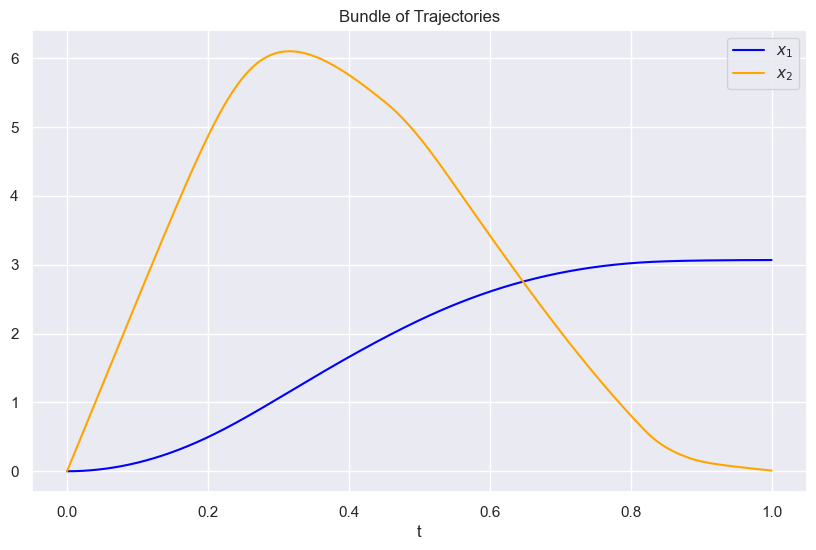

In [156]:
plot_sheaf(validation_env, agent, initial_state=np.array([0, 0, 0]))

In [174]:
# torch.save(agent.pi_model, 'models/flat_orientation_pi_135.pth')
# torch.save(agent.v_model, 'models/flat_orientation_v_135.pth')

### Testing

In [115]:
dt = 1e-4
euler_env = FlatOrientation(dt=dt, integration='Euler')
rk45_env = FlatOrientation(dt=dt, integration='RK45')

In [116]:
get_reward(euler_env, AnaliticalAgent()), get_reward(rk45_env, AnaliticalAgent())

(-118.43969626688481, -118.43969644452312)

0.0009423521327827089 0.0018849555936547922


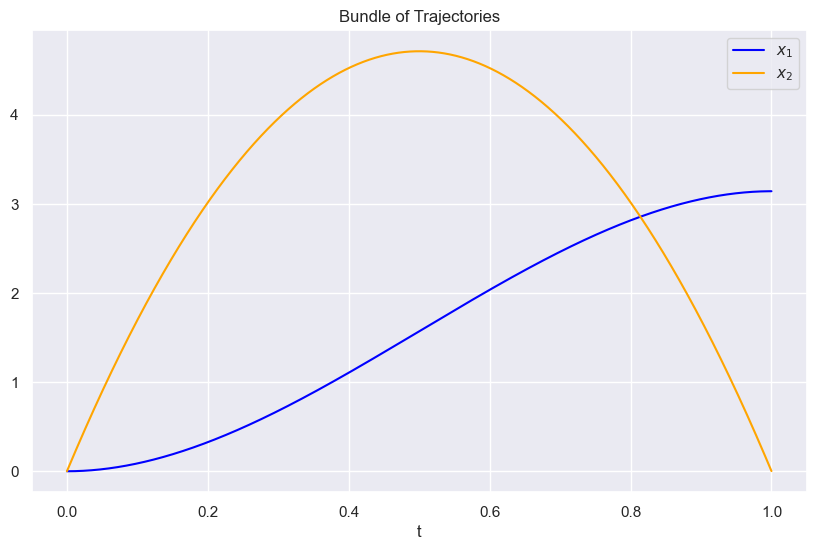

In [117]:
plot_sheaf(euler_env, AnaliticalAgent(), initial_state=[0, 0, 0])

0.0009424463801539495 0.0018849555939234805


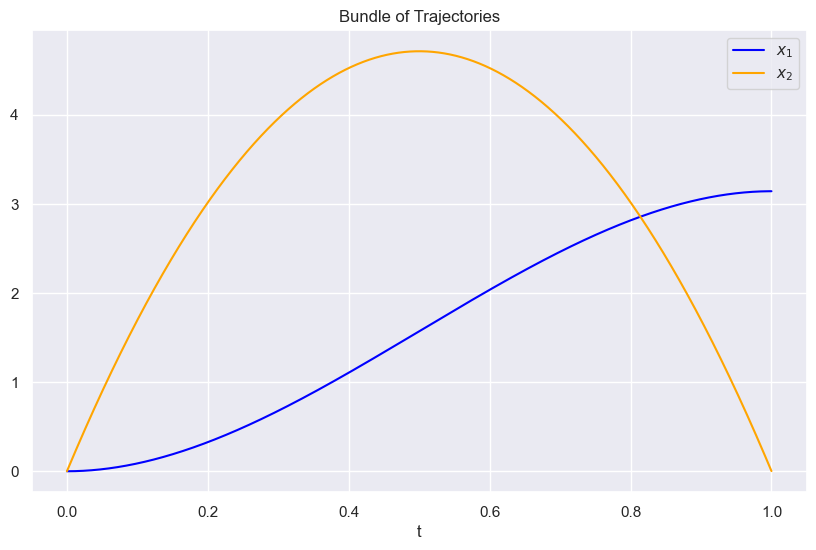

In [118]:
plot_sheaf(rk45_env, AnaliticalAgent(), initial_state=[0, 0, 0])

## II. Стабилизация на отрезке времени 3 секунды.

### Обучение

In [227]:
env = FlatOrientation(dt=1e-1, t_end=3, reward_function=stability_reward, integration='Euler')

In [170]:
agent = PPO(
    state_dim=3,
    action_dim=1, 
    max_action=25, 
    observable_states=[0, 1, 2],
    gamma=1
)

# agent.pi_model = torch.load('models/flat_orientation_pi_140.pth')
# agent.v_model = torch.load('models/flat_orientation_v_140.pth')

In [185]:
train_ppo(
    env, 
    agent, 
    episode_n=20, 
    trajectory_n=500, 
    advantage='default',
)

0: mean reward = -3274.2415916718637
1: mean reward = -2662.880812894312
2: mean reward = -3315.6896921622306
3: mean reward = -2255.2854374811027
4: mean reward = -2227.146756134305
5: mean reward = -2141.2847417995463
6: mean reward = -1890.2682378052211
7: mean reward = -1893.62617235904
8: mean reward = -1799.6289076766689
9: mean reward = -1721.9850522487936
10: mean reward = -1701.2123144985358
11: mean reward = -1696.2076376052935
12: mean reward = -1565.3866882941047
13: mean reward = -1698.7209267817418
14: mean reward = -1615.8999229915223
15: mean reward = -1615.382020202946
16: mean reward = -1558.4464067984297
17: mean reward = -1468.2437179923836
18: mean reward = -1491.3809967304219
19: mean reward = -1532.1407378919864


In [186]:
history = []
history.extend(agent.history)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


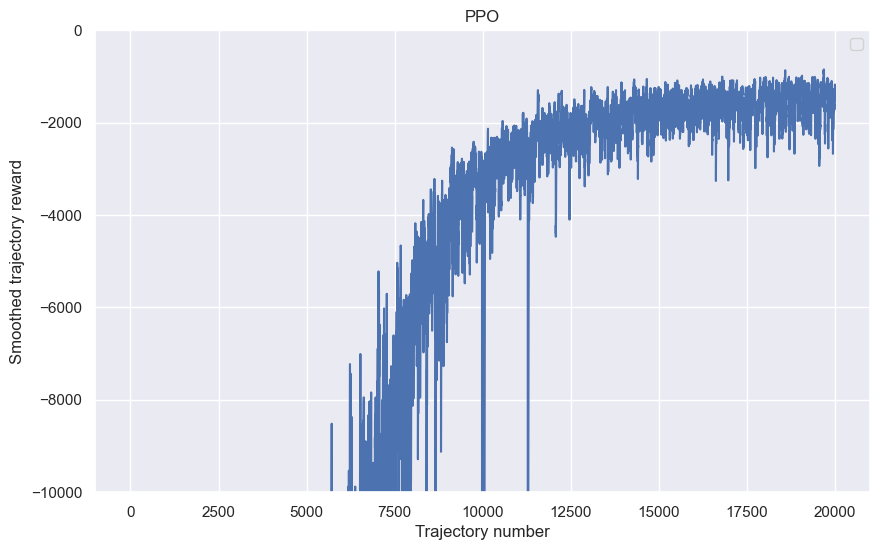

In [188]:
plot_history(history, ylim=[-10**4, 0])

### Валидация

In [228]:
validation_env = FlatOrientation(dt=1e-2, t_end=3, reward_function=stability_reward)

In [229]:
validation(validation_env, agent, validation_n=10, prediction=True)

-1152086.7871094372

### Управление:

In [222]:
traj = agent.get_trajectory(validation_env, prediction=True, initial_state=np.array([0, 0, 0]))

In [225]:
traj['rewards']

[-2.9973943113909627,
 -2.8572107692925783,
 -2.7136040615896126,
 -2.4919274559434506,
 -2.252521839657711,
 -2.0186046725838334,
 -1.792933095479384,
 -1.5779692650351445,
 -1.3757841418209955,
 -1.2133077880960719,
 -1.1108462340665575,
 -1.01215428551478,
 -0.9175520377830617,
 -0.8113133981917053,
 -0.7037125584474779,
 -0.6050065719196231,
 -0.5151764608527287,
 -0.4340919336567117,
 -0.36152516389266565,
 -0.2971654849187894,
 -0.24063564711696245,
 -0.19150598155852094,
 -0.14930903828834743,
 -0.11355338942387846,
 -0.0837340657313348,
 -0.05934369503029302,
 -0.039880565285344005,
 -0.02814402643596182,
 -0.02211552582357456,
 -0.017067683312030228,
 -0.012884609567914254,
 -0.009461999051636418,
 -0.006705968017121365,
 -0.00453243116959218,
 -0.0028660162732946047,
 -0.001639361058308033,
 -0.0007924566269161915,
 -0.0002717942236076798,
 -2.9852298535488903e-05,
 -2.447679348370327e-05,
 -0.00021834463126325866,
 -0.0005784899612084704,
 -0.001075852767181127,
 -0.00168487

In [214]:
def get_reward(env, agent):
    traj = agent.get_trajectory(env, prediction=True, initial_state=np.array([0, 0, 0]))
    return sum(traj['rewards'])

In [218]:
get_reward(env, agent)

-49.79326387698876

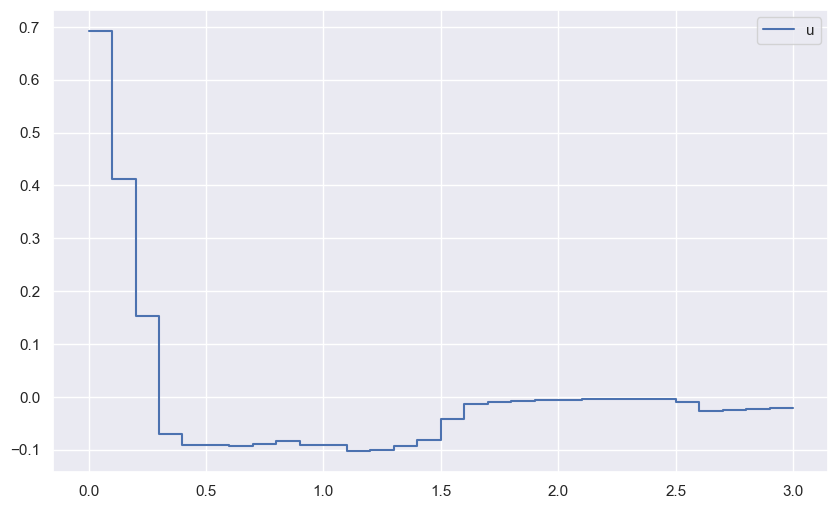

In [219]:
plot_u(env, agent)

-0.03683881794149446 -0.06098676100373273


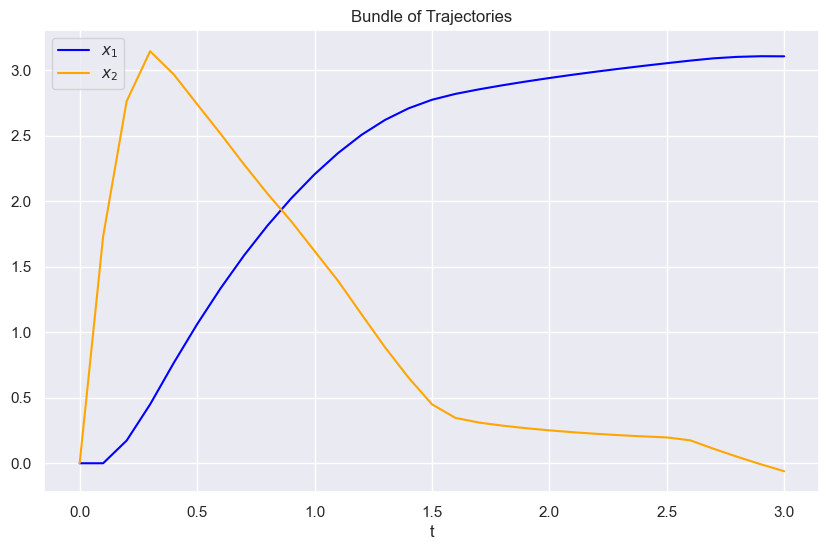

In [220]:
plot_sheaf(env, agent, initial_state=np.array([0, 0, 0]))

In [ ]:
# torch.save(agent.pi_model, 'models/flat_orientation_pi_135.pth')
# torch.save(agent.v_model, 'models/flat_orientation_v_135.pth')